In [194]:
#import pyspark
#from pyspark import SparkContext
# from pyspark.sql.window import Window
# from pyspark.sql import functions as F
# from pyspark.sql import types as T

import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Read Boarding Data

In [2]:
#boarding_data = pd.read_json('/local/tarciso/masters/data/bus_trips/preliminary-exp-sample-data/ticketing-sample/doc1-2017051015.txt', lines=True)
boarding_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/test/doc1-2017_05_10.csv')

In [3]:
boarding_data.head()

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M
1,542,BAIRRO NOVO B,GA117,2357837,17:25:14,09/05/17,23/03/72,F
2,000,OPER S/LINHA,09053,2357837,17:57:33,09/05/17,23/03/72,F
3,000,OPER S/LINHA,09053,2357837,17:57:28,09/05/17,23/03/72,F
4,021,INTERB II ANTI H,08046,1937533,20:17:34,09/05/17,26/01/72,F


In [4]:
boardings_total = len(boarding_data)

In [5]:
boarding_data.dtypes

CODLINHA          object
NOMELINHA         object
CODVEICULO        object
NUMEROCARTAO       int64
HORAUTILIZACAO    object
DATAUTILIZACAO    object
DATANASCIMENTO    object
SEXO              object
dtype: object

#### Adding datetime column to ticketing dataframe 

In [9]:
boarding_data['boarding_datetime'] = pd.to_datetime(boarding_data['DATAUTILIZACAO'] + ' ' + boarding_data['HORAUTILIZACAO'],format='%d/%m/%y %H:%M:%S')

#### Checking number of boardings on route 000

In [10]:
boardings_000 = len(boarding_data[boarding_data['CODLINHA'] == '000'])

In [11]:
print boardings_000, boardings_total, boardings_000/float(boardings_total)

134629 320292 0.420332071984


#### Looking at 000 boardings in more detail

In [12]:
boardings_000_df = boarding_data[boarding_data['CODLINHA'] == '000']

In [13]:
boardings_000_df.head(20)

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57
2,000,OPER S/LINHA,09053,2357837,17:57:33,09/05/17,23/03/72,F,2017-05-09 17:57:33
3,000,OPER S/LINHA,09053,2357837,17:57:28,09/05/17,23/03/72,F,2017-05-09 17:57:28
13,000,OPER S/LINHA,03009,3591720,18:57:22,09/05/17,28/08/84,F,2017-05-09 18:57:22
15,000,OPER S/LINHA,03031,1225547,07:20:19,09/05/17,29/12/63,M,2017-05-09 07:20:19
17,000,OPER S/LINHA,05040,2699543,15:29:11,09/05/17,17/01/79,F,2017-05-09 15:29:11
20,000,OPER S/LINHA,09005,2788103,06:59:45,09/05/17,14/09/76,F,2017-05-09 06:59:45
22,000,OPER S/LINHA,03037,2900987,17:00:00,09/05/17,01/06/89,F,2017-05-09 17:00:00
25,000,OPER S/LINHA,05056,1947358,07:42:22,09/05/17,02/07/63,M,2017-05-09 07:42:22
26,000,OPER S/LINHA,09029,3543165,07:00:15,09/05/17,22/02/65,M,2017-05-09 07:00:15


### Find boarding stations stop ids for line 000 boarding entries

#### Read Line 000 Codes translation table

In [14]:
line_000_terminals = pd.read_csv('/local/tarciso/masters/data/urbs/line-000-terminals-translation-table.csv', dtype = {'URBS_CODE': str})

In [15]:
line_000_terminals.head()

,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,TERMINAL BOQUEIRÃO,00001,14489,-25.516723,-49.230568
1,000,TERMINAL BOQUEIRÃO,00002,14489,-25.516723,-49.230568
2,000,TERMINAL BOQUEIRÃO,00003,14489,-25.516723,-49.230568
3,000,TERMINAL CARMO,00004,14485,-25.501311,-49.237825
4,000,TERMINAL CARMO,00005,14485,-25.501311,-49.237825


#### Match CODVEICULO to URBS_CODE to find line 000 boarding stations

In [16]:
matched_000_stations = boardings_000_df.merge(line_000_terminals, left_on='CODVEICULO', right_on='URBS_CODE', how='inner') \
                        .sort_values(by='DATAUTILIZACAO')

In [17]:
matched_000_stations.head(100)

,CODLINHA,NOMELINHA,CODVEICULO,NUMEROCARTAO,HORAUTILIZACAO,DATAUTILIZACAO,DATANASCIMENTO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
0,000,OPER S/LINHA,00070,1353891,11:05:57,09/05/17,22/11/58,M,2017-05-09 11:05:57,000,TERMINAL HAUER,00070,14487,-25.481900,-49.247078
81916,000,OPER S/LINHA,03036,3103755,07:06:52,09/05/17,14/01/96,F,2017-05-09 07:06:52,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81915,000,OPER S/LINHA,03036,3476595,15:54:33,09/05/17,27/11/92,M,2017-05-09 15:54:33,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81914,000,OPER S/LINHA,03036,3772075,18:08:20,09/05/17,27/10/84,F,2017-05-09 18:08:20,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81913,000,OPER S/LINHA,03036,3483992,16:16:02,09/05/17,26/08/90,M,2017-05-09 16:16:02,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81912,000,OPER S/LINHA,03036,3639633,12:18:45,09/05/17,18/09/84,F,2017-05-09 12:18:45,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81911,000,OPER S/LINHA,03036,996194,14:11:36,09/05/17,04/06/61,F,2017-05-09 14:11:36,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81910,000,OPER S/LINHA,03036,907747,17:59:14,09/05/17,22/08/87,F,2017-05-09 17:59:14,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81909,000,OPER S/LINHA,03036,874341,18:08:23,09/05/17,10/03/72,F,2017-05-09 18:08:23,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777
81908,000,OPER S/LINHA,03036,708808,17:47:05,09/05/17,26/05/53,F,2017-05-09 17:47:05,000,ESTAÇÃO SILVA JARDIM - SENT. CENTRO,03036,26105,-25.448323,-49.287777


In [18]:
num_matched_stations = len(matched_000_stations)

In [19]:
print num_matched_stations, boardings_000, num_matched_stations/float(boardings_000)

122864 134629 0.912611695846


### Find Candidate bus routes for each boarding event

#### Read GPS data for the same day

In [35]:
#gps_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/buste-v3a/may_jun_jul/single-csvs/2017_05_09_veiculos.csv', dtype = {'route': str}, na_values='-')
gps_data = pd.read_csv('/local/tarciso/masters/data/bus_trips/test/buste-maio/2017_05_10_veiculos.csv', dtype = {'route': str}, na_values='-')

In [36]:
gps_data.head()

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,distanceToShapePoint,timestamp,stopPointId,problem,birthdate,cardTimestamp,lineName,cardNum,gender
0,500,2.0,4130,6464167,-25.433790,-49.270262,10543.422,GE718,NaN,-25.433916,-49.270425,21.556105,06:58:25,27560,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN
1,500,4.0,4130,6464041,-25.459174,-49.258160,7268.131,GE718,NaN,-25.459181,-49.258193,3.460972,07:07:26,25471,TRIP_PROBLEM,NaN,NaN,NaN,NaN,NaN
2,500,5.0,4130,6463945,-25.481825,-49.246977,4513.260,GE718,NaN,NaN,NaN,NaN,07:57:57,27551,BETWEEN,NaN,NaN,NaN,NaN,NaN
3,500,3.0,4130,6463945,-25.481825,-49.246977,4513.260,GE718,NaN,-25.481915,-49.247050,12.410537,08:00:09,27551,TRIP_PROBLEM,NaN,NaN,NaN,NaN,NaN
4,500,1.0,4130,6463793,-25.516848,-49.230057,0.000,GE718,NaN,-25.516915,-49.229840,23.004353,08:10:07,27537,TRIP_PROBLEM,NaN,NaN,NaN,NaN,NaN


In [37]:
gps_data.dtypes

route                     object
tripNum                  float64
shapeId                    int64
shapeSequence              int64
shapeLat                 float64
shapeLon                 float64
distanceTraveledShape    float64
busCode                   object
gpsPointId               float64
gpsLat                   float64
gpsLon                   float64
distanceToShapePoint     float64
timestamp                 object
stopPointId                int64
problem                   object
birthdate                 object
cardTimestamp             object
lineName                  object
cardNum                  float64
gender                    object
dtype: object

In [38]:
len(gps_data)

1298680

#### Add date and datetime to gps dataframe

In [40]:
gps_data['date'] = '2017-05-09'
gps_data['gps_datetime'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['timestamp'],format='%Y-%m-%d %H:%M:%S')
gps_data['boarding_datetime'] = pd.to_datetime(gps_data['date'] + ' ' + gps_data['cardTimestamp'],format='%Y-%m-%d %H:%M:%S')
gps_data['date'] = pd.to_datetime(gps_data['date'], format='%Y-%m-%d') 

In [41]:
gps_data[['date','gps_datetime','boarding_datetime']]

,date,gps_datetime,boarding_datetime
0,2017-05-09,2017-05-09 06:58:25,NaT
1,2017-05-09,2017-05-09 07:07:26,NaT
2,2017-05-09,2017-05-09 07:57:57,NaT
3,2017-05-09,2017-05-09 08:00:09,NaT
4,2017-05-09,2017-05-09 08:10:07,NaT
5,2017-05-09,2017-05-09 06:53:44,NaT
6,2017-05-09,2017-05-09 07:18:04,NaT
7,2017-05-09,2017-05-09 07:22:26,NaT
8,2017-05-09,2017-05-09 07:26:47,NaT
9,2017-05-09,2017-05-09 07:28:04,NaT


#### Analyzing Boarding and GPS Data

In [42]:
boarding_data[['NUMEROCARTAO','DATAUTILIZACAO','HORAUTILIZACAO','CODLINHA','CODVEICULO']] \
    .sort_values(['NUMEROCARTAO','DATAUTILIZACAO']).head(100)

,NUMEROCARTAO,DATAUTILIZACAO,HORAUTILIZACAO,CODLINHA,CODVEICULO
243380,228696,09/05/17,07:01:00,000,08024
243381,228696,09/05/17,13:55:35,000,05312
61748,229948,09/05/17,06:29:09,654,HA017
199680,233641,09/05/17,12:08:17,021,04020
199681,233641,09/05/17,06:39:21,000,01026
199751,257342,09/05/17,17:24:51,000,01021
199752,257342,09/05/17,07:48:58,511,EA172
14035,272904,09/05/17,17:24:52,000,03047
199772,300327,09/05/17,16:52:22,000,03057
199773,300327,09/05/17,06:56:45,OPC,HA240


In [156]:
first_cols = ['cardNum', 'boarding_datetime','gps_datetime','route','busCode','stopPointId']
other_cols = [col for col in gps_data.columns if col not in first_cols]
cols_order = first_cols + other_cols
boarding_key_cols = ['cardNum','boarding_datetime']
gps_by_boarding = gps_data[cols_order] \
    .dropna(subset=boarding_key_cols) \
    .sort_values(boarding_key_cols)
gps_by_boarding.head(100)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLat,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date
1140069,229948.0,2017-05-09 06:29:09,2017-05-09 06:20:40,654,HA017,32429,32.0,2106,6040888,-25.500277,...,NaN,NaN,NaN,06:20:40,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1140684,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,-25.492601,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1140935,229948.0,2017-05-09 06:29:09,2017-05-09 12:55:17,654,HA017,35927,39.0,2106,6040805,-25.495342,...,-25.495396,-49.309661,6.075716,12:55:17,NO_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
1141556,229948.0,2017-05-09 06:29:09,2017-05-09 06:17:11,654,HA017,36102,32.0,2106,6040906,-25.505621,...,-25.505561,-49.326645,7.356053,06:17:11,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09
609704,257342.0,2017-05-09 07:48:58,2017-05-09 07:38:32,511,EA172,40444,4.0,2746,5846145,-25.501153,...,NaN,NaN,NaN,07:38:32,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
610234,257342.0,2017-05-09 07:48:58,2017-05-09 07:10:28,511,EA172,28437,51.0,2746,5846133,-25.503343,...,NaN,NaN,NaN,07:10:28,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
610545,257342.0,2017-05-09 07:48:58,2017-05-09 06:06:03,511,EA172,29827,49.0,2746,5846093,-25.510742,...,NaN,NaN,NaN,06:06:03,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
610876,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,NaN,NaN,NaN,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09
866834,300327.0,2017-05-09 06:56:45,2017-05-09 06:47:36,654,HA240,36086,6.0,2953,3848590,-25.497653,...,NaN,NaN,NaN,06:47:36,BETWEEN,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09
866918,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,2.0,2106,6040871,-25.501307,...,-25.501313,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09


#### Selecting best match by using timediff between GPS and Boarding datetimes

In [157]:
gps_by_boarding['match_diff'] = (gps_by_boarding['boarding_datetime'] - gps_by_boarding['gps_datetime']).astype('timedelta64[s]')

In [158]:
gps_by_boarding.head(100)

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
1140069,229948.0,2017-05-09 06:29:09,2017-05-09 06:20:40,654,HA017,32429,32.0,2106,6040888,-25.500277,...,NaN,NaN,06:20:40,BETWEEN,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,509.0
1140684,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,18.0
1140935,229948.0,2017-05-09 06:29:09,2017-05-09 12:55:17,654,HA017,35927,39.0,2106,6040805,-25.495342,...,-49.309661,6.075716,12:55:17,NO_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,-23168.0
1141556,229948.0,2017-05-09 06:29:09,2017-05-09 06:17:11,654,HA017,36102,32.0,2106,6040906,-25.505621,...,-49.326645,7.356053,06:17:11,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,718.0
609704,257342.0,2017-05-09 07:48:58,2017-05-09 07:38:32,511,EA172,40444,4.0,2746,5846145,-25.501153,...,NaN,NaN,07:38:32,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,626.0
610234,257342.0,2017-05-09 07:48:58,2017-05-09 07:10:28,511,EA172,28437,51.0,2746,5846133,-25.503343,...,NaN,NaN,07:10:28,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,2310.0
610545,257342.0,2017-05-09 07:48:58,2017-05-09 06:06:03,511,EA172,29827,49.0,2746,5846093,-25.510742,...,NaN,NaN,06:06:03,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,6175.0
610876,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,NaN,NaN,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,44.0
866834,300327.0,2017-05-09 06:56:45,2017-05-09 06:47:36,654,HA240,36086,6.0,2953,3848590,-25.497653,...,NaN,NaN,06:47:36,BETWEEN,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,549.0
866918,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,2.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0


In [159]:
gps_by_boarding_filtered = gps_by_boarding.loc[gps_by_boarding[np.abs(gps_by_boarding['match_diff']) <= 3600].groupby(['cardNum','boarding_datetime'])['match_diff'].idxmin()]
gps_by_boarding_filtered

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
1140684,229948.0,2017-05-09 06:29:09,2017-05-09 06:28:51,654,HA017,35349,1.0,2106,6040781,-25.492611,...,-49.303553,20.905151,06:28:51,TRIP_PROBLEM,28/04/95,06:29:09,CAMPO ALEGRE,F,2017-05-09,18.0
610876,257342.0,2017-05-09 07:48:58,2017-05-09 07:48:14,511,EA172,31195,22.0,2746,5846156,-25.498727,...,NaN,NaN,07:48:14,BETWEEN,24/01/71,07:48:58,SÃO FRANCISCO,F,2017-05-09,44.0
866918,300327.0,2017-05-09 06:56:45,2017-05-09 06:55:54,654,HA240,36094,2.0,2106,6040871,-25.501307,...,-49.319971,0.737270,06:55:54,TRIP_PROBLEM,20/05/59,06:56:45,OP. CONTIGENCIA,F,2017-05-09,51.0
370582,304127.0,2017-05-09 10:24:50,2017-05-09 10:23:32,175,BC010,31749,11.0,2743,5404834,-25.451146,...,-49.252913,39.855495,10:23:32,NO_PROBLEM,09/06/54,10:24:50,BOM RETIRO / PUC,M,2017-05-09,78.0
679507,304127.0,2017-05-09 10:57:36,2017-05-09 10:57:08,370,LC016,25428,8.0,3669,6592082,-25.436333,...,NaN,NaN,10:57:08,BETWEEN,09/06/54,10:57:36,RUA XV / BARIGUI,M,2017-05-09,28.0
1058219,304627.0,2017-05-09 14:17:23,2017-05-09 13:46:49,370,BC032,29938,13.0,1887,5511235,-25.442560,...,-49.288110,5.389940,13:46:49,NO_PROBLEM,05/04/53,14:17:23,RUA XV / BARIGUI,F,2017-05-09,1834.0
890665,304627.0,2017-05-09 16:24:40,2017-05-09 16:05:27,370,LC020,30157,6.0,3669,6592013,-25.444290,...,-49.291258,5.801413,16:05:27,NO_PROBLEM,05/04/53,16:24:40,RUA XV / BARIGUI,F,2017-05-09,1153.0
206128,306135.0,2017-05-09 07:56:49,2017-05-09 07:56:48,777,JC004,32097,6.0,2194,4299781,-25.446370,...,-49.275308,32.238018,07:56:48,TRIP_PROBLEM,29/10/52,07:56:49,V. VELHA,M,2017-05-09,1.0
402017,306573.0,2017-05-09 07:50:41,2017-05-09 07:48:58,323,DA033,32543,18.0,1861,5583329,-25.450101,...,-49.206238,5.976702,07:48:58,NO_PROBLEM,03/04/59,07:50:41,MAD. CENTENÁRIO,F,2017-05-09,103.0
606072,310241.0,2017-05-09 17:55:48,2017-05-09 17:55:39,468,DC090,31505,3.0,1926,4418075,-25.467945,...,NaN,NaN,17:55:39,BETWEEN,13/01/72,17:55:48,JD. ITIBERÊ,M,2017-05-09,9.0


In [160]:
gps_by_boarding_filtered['match_diff'].describe()

count    147830.000000
mean        168.362369
std         440.186495
min       -3595.000000
25%          19.000000
50%          53.000000
75%         142.000000
max        3600.000000
Name: match_diff, dtype: float64

In [161]:
num_single_boardings = len(gps_by_boarding.drop_duplicates(subset=boarding_key_cols))
num_matched_boardings = len(gps_by_boarding_filtered)
num_missed_boardings = num_single_boardings - num_matched_boardings
perc_matched_boardings = num_matched_boardings/float(num_single_boardings)
perc_missed_boardings = num_missed_boardings/float(num_single_boardings)
print "single boardings: {}, matched boardings: {} ({}), missed boardings = {} ({})".format(num_single_boardings, num_matched_boardings, perc_matched_boardings, num_missed_boardings, perc_missed_boardings)

single boardings: 152743, matched boardings: 147830 (0.967834859863), missed boardings = 4913 (0.0321651401374)


In [163]:
all_boardings = gps_by_boarding[boarding_key_cols].drop_duplicates()
matched_boardings = gps_by_boarding_filtered[boarding_key_cols].drop_duplicates()
missed_boardings = pd.concat([all_boardings,matched_boardings]).drop_duplicates(keep=False)
print len(missed_boardings)
missed_boardings

4913


,cardNum,boarding_datetime
691455,305647.0,2017-05-09 17:08:47
266012,316234.0,2017-05-09 07:06:26
176840,331502.0,2017-05-09 13:05:31
176841,331502.0,2017-05-09 13:05:33
1091260,334355.0,2017-05-09 06:16:23
303873,341560.0,2017-05-09 07:50:18
149881,353766.0,2017-05-09 08:15:06
1041194,367413.0,2017-05-09 18:33:38
1251667,368045.0,2017-05-09 06:08:12
951237,372350.0,2017-05-09 06:16:11


In [206]:
gps_by_boarding_missed = gps_by_boarding.merge(missed_boardings, on=boarding_key_cols, how='inner')
print len(gps_by_boarding_missed)

13263


In [207]:
gps_by_boarding_missed

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,305647.0,2017-05-09 17:08:47,2017-05-09 14:37:05,170,BC297,36673,3.0,2747,5200673,-25.416165,...,NaN,NaN,14:37:05,BETWEEN,07/11/71,17:08:47,CABRAL / OSÓRIO,F,2017-05-09,9102.0
1,316234.0,2017-05-09 07:06:26,2017-05-09 12:44:19,777,JC008,26149,24.0,2195,4299860,-25.435179,...,-49.273396,9.121001,12:44:19,NO_PROBLEM,06/01/75,07:06:26,V. VELHA,F,2017-05-09,-20273.0
2,316234.0,2017-05-09 07:06:26,2017-05-09 12:58:42,777,JC008,26583,15.0,2195,4299885,-25.439721,...,-49.269480,20.496515,12:58:42,TRIP_PROBLEM,06/01/75,07:06:26,V. VELHA,F,2017-05-09,-21136.0
3,316234.0,2017-05-09 07:06:26,2017-05-09 12:59:49,777,JC008,32903,15.0,2195,4299895,-25.442293,...,NaN,NaN,12:59:49,BETWEEN,06/01/75,07:06:26,V. VELHA,F,2017-05-09,-21203.0
4,331502.0,2017-05-09 13:05:31,2017-05-09 11:41:41,233,BA129,35111,4.0,1812,6295754,-25.374537,...,-49.222143,5.680695,11:41:41,NO_PROBLEM,29/12/61,13:05:31,OLARIA,F,2017-05-09,5030.0
5,331502.0,2017-05-09 13:05:31,2017-05-09 11:54:08,233,BA129,34994,5.0,1812,6295724,-25.374731,...,NaN,NaN,11:54:08,BETWEEN,29/12/61,13:05:31,OLARIA,F,2017-05-09,4283.0
6,331502.0,2017-05-09 13:05:31,2017-05-09 11:59:31,233,BA129,34989,15.0,1812,6295673,-25.368072,...,-49.208821,1.375438,11:59:31,NO_PROBLEM,29/12/61,13:05:31,OLARIA,F,2017-05-09,3960.0
7,331502.0,2017-05-09 13:05:31,2017-05-09 10:39:46,233,BA129,30460,35.0,1812,6295779,-25.376838,...,-49.223898,10.449590,10:39:46,NO_PROBLEM,29/12/61,13:05:31,OLARIA,F,2017-05-09,8745.0
8,331502.0,2017-05-09 13:05:31,2017-05-09 11:19:56,233,BA129,34991,37.0,1812,6295692,-25.371448,...,NaN,NaN,11:19:56,BETWEEN,29/12/61,13:05:31,OLARIA,F,2017-05-09,6335.0
9,331502.0,2017-05-09 13:05:33,2017-05-09 11:41:41,233,BA129,35111,4.0,1812,6295754,-25.374537,...,-49.222143,5.680695,11:41:41,NO_PROBLEM,29/12/61,13:05:33,OLARIA,F,2017-05-09,5032.0


#### Check the distribution of match_diff variable to evaluate the effectiveness of the threshold value

In [209]:
best_missed_boarding_matches = gps_by_boarding_missed.copy()
#best_missed_boarding_matches['match_diff'] = np.abs(best_missed_boarding_matches['match_diff'])
best_missed_boarding_matches = best_missed_boarding_matches.loc[best_missed_boarding_matches.groupby(['cardNum','boarding_datetime'])['match_diff'].idxmin()]
best_missed_boarding_matches['match_diff'].describe()

count     4913.000000
mean     -2800.882556
std      21034.774623
min     -42461.000000
25%     -23844.000000
50%       3897.000000
75%       9859.000000
max      47925.000000
Name: match_diff, dtype: float64

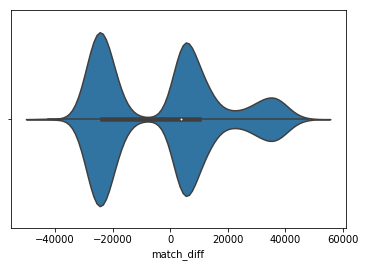

In [210]:
sns.violinplot(x="match_diff", data=best_missed_boarding_matches)

In [214]:
total_gps_data = len(gps_data)
gps_key_cols = ['route','busCode','tripNum','stopPointId']
gps_single_records = gps_data.dropna(subset=gps_key_cols).drop_duplicates(subset=gps_key_cols)
gps_with_no_boarding = gps_single_records[np.isnan(gps_single_records['cardNum'])]
num_single_gps_records = len(gps_single_records)
num_gps_no_boarding = len(gps_with_no_boarding)

print "total gps data: {}, num single GPS records: {}, num single GPS with no boarding: {} ({}), diff: {}" \
    .format(total_gps_data, num_single_gps_records, num_gps_no_boarding, 
            num_gps_no_boarding/float(num_single_gps_records), 
            num_single_gps_records - num_gps_no_boarding)

total gps data: 1298680, num single GPS records: 560992, num single GPS with no boarding: 484871 (0.864310007986), diff: 76121


#### Create GPS-boarding dataframe containing all unique GPS records and unique selected boarding records

In [242]:
missed_boarding_gps = gps_by_boarding_missed.copy()
missed_boarding_gps[['birthdate','cardTimestamp','lineName','cardNum','gender','boarding_datetime']] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

In [243]:
missed_boarding_gps

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,NaN,NaN,2017-05-09 14:37:05,170,BC297,36673,3.0,2747,5200673,-25.416165,...,NaN,NaN,14:37:05,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,9102.0
1,NaN,NaN,2017-05-09 12:44:19,777,JC008,26149,24.0,2195,4299860,-25.435179,...,-49.273396,9.121001,12:44:19,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,-20273.0
2,NaN,NaN,2017-05-09 12:58:42,777,JC008,26583,15.0,2195,4299885,-25.439721,...,-49.269480,20.496515,12:58:42,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,-21136.0
3,NaN,NaN,2017-05-09 12:59:49,777,JC008,32903,15.0,2195,4299895,-25.442293,...,NaN,NaN,12:59:49,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,-21203.0
4,NaN,NaN,2017-05-09 11:41:41,233,BA129,35111,4.0,1812,6295754,-25.374537,...,-49.222143,5.680695,11:41:41,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,5030.0
5,NaN,NaN,2017-05-09 11:54:08,233,BA129,34994,5.0,1812,6295724,-25.374731,...,NaN,NaN,11:54:08,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,4283.0
6,NaN,NaN,2017-05-09 11:59:31,233,BA129,34989,15.0,1812,6295673,-25.368072,...,-49.208821,1.375438,11:59:31,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,3960.0
7,NaN,NaN,2017-05-09 10:39:46,233,BA129,30460,35.0,1812,6295779,-25.376838,...,-49.223898,10.449590,10:39:46,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,8745.0
8,NaN,NaN,2017-05-09 11:19:56,233,BA129,34991,37.0,1812,6295692,-25.371448,...,NaN,NaN,11:19:56,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,6335.0
9,NaN,NaN,2017-05-09 11:41:41,233,BA129,35111,4.0,1812,6295754,-25.374537,...,-49.222143,5.680695,11:41:41,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,5032.0


In [244]:
print missed_boarding_gps.columns
print gps_with_no_boarding[cols_order].columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')
Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date'],
      dtype='object')


In [245]:
gps_with_no_boarding = gps_with_no_boarding[cols_order]
gps_with_no_boarding['match_diff'] = np.nan
gps_without_or_notselected_boarding = pd.concat([gps_with_no_boarding, missed_boarding_gps], axis=0) \
            .drop_duplicates(subset=gps_key_cols)
gps_without_or_notselected_boarding

,cardNum,boarding_datetime,gps_datetime,route,busCode,stopPointId,tripNum,shapeId,shapeSequence,shapeLat,...,gpsLon,distanceToShapePoint,timestamp,problem,birthdate,cardTimestamp,lineName,gender,date,match_diff
0,NaN,NaT,2017-05-09 06:58:25,500,GE718,27560,2.0,4130,6464167,-25.433790,...,-49.270425,21.556105,06:58:25,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
1,NaN,NaT,2017-05-09 07:07:26,500,GE718,25471,4.0,4130,6464041,-25.459174,...,-49.258193,3.460972,07:07:26,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
2,NaN,NaT,2017-05-09 07:57:57,500,GE718,27551,5.0,4130,6463945,-25.481825,...,NaN,NaN,07:57:57,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
3,NaN,NaT,2017-05-09 08:00:09,500,GE718,27551,3.0,4130,6463945,-25.481825,...,-49.247050,12.410537,08:00:09,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
4,NaN,NaT,2017-05-09 08:10:07,500,GE718,27537,1.0,4130,6463793,-25.516848,...,-49.229840,23.004353,08:10:07,TRIP_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
5,NaN,NaT,2017-05-09 06:53:44,500,GE718,25515,2.0,4130,6464140,-25.438837,...,-49.268180,12.105323,06:53:44,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
6,NaN,NaT,2017-05-09 07:18:04,500,GE718,27472,4.0,4130,6463875,-25.501550,...,NaN,NaN,07:18:04,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
7,NaN,NaT,2017-05-09 07:22:26,500,GE718,27537,5.0,4130,6463793,-25.516848,...,-49.229913,15.014615,07:22:26,NO_PROBLEM,NaN,NaN,NaN,NaN,2017-05-09,NaN
8,NaN,NaT,2017-05-09 07:26:47,500,GE718,27472,1.0,4130,6463875,-25.501550,...,NaN,NaN,07:26:47,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN
9,NaN,NaT,2017-05-09 07:28:04,500,GE718,27551,1.0,4130,6463945,-25.481825,...,NaN,NaN,07:28:04,BETWEEN,NaN,NaN,NaN,NaN,2017-05-09,NaN


In [246]:
gps_without_or_notselected_boarding.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')

In [248]:
print "num unique GPS records not matched: {}".format(len(gps_without_or_notselected_boarding))

num unique GPS records not matched: 486419


In [249]:
print gps_by_boarding_filtered.columns
print gps_without_or_notselected_boarding.columns

Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')
Index([u'cardNum', u'boarding_datetime', u'gps_datetime', u'route', u'busCode',
       u'stopPointId', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'gpsPointId', u'gpsLat',
       u'gpsLon', u'distanceToShapePoint', u'timestamp', u'problem',
       u'birthdate', u'cardTimestamp', u'lineName', u'gender', u'date',
       u'match_diff'],
      dtype='object')


In [ ]:
buste_fixed_result = pd.concat([gps_by_boarding_filtered, gps_without_or_notselected_boarding]) \
                        .drop_duplicates(subset=[gps_key_cols])
buste_fixed_result

### Match BUSTE GPS entries with their respective parent stop codes

#### Read GTFS stops file

In [82]:
stops_df = pd.read_csv('/local/tarciso/data/gtfs/curitiba/stops.txt')

In [83]:
stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,70,104505,Terminal Campina do Siqueira - 303 - Centenári...,Terminal Campina do Siqueira - Campo Comprido,-25.435724,-49.306998,NaN,NaN,0,14506.0,NaN,NaN
1,270,104905,Terminal Carmo - 030 - Interbairros III,Terminal Carmo - 030 - Interbairros III (Senti...,-25.501341,-49.237597,NaN,NaN,0,14485.0,NaN,NaN
2,276,105606,Terminal Oficinas - 030 - Interbairros III,Terminal Oficinas - 030 - Interbairros III (Se...,-25.451550,-49.214917,NaN,NaN,0,14481.0,NaN,NaN
3,299,105603,Terminal Oficinas - 030 - Interbairros III,Terminal Oficinas - 030 - Interbairros III (Se...,-25.451665,-49.215086,NaN,NaN,0,14481.0,NaN,NaN
4,308,104907,Terminal Carmo - 030 - Interbairros III,Terminal Carmo - 030 - Interbairros III (Senti...,-25.501311,-49.237825,NaN,NaN,0,14485.0,NaN,NaN


In [84]:
stops_parent_stations = stops_df[['stop_id','parent_station']]

#### Add parent station ID to GPS Boardings data

In [85]:
gps_stops_with_parent_stations = gps_data.merge(stops_parent_stations, left_on='stopPointId', right_on='stop_id', how='inner')

In [86]:
gps_stops_with_parent_stations.head()

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date,gps_datetime,stop_id,parent_station
0,500,2.0,4130,6464140,-25.438837,-49.268129,9735.966,GE718,NaN,-25.438738,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 06:53:44,25515,NaN
1,500,4.0,4130,6464140,-25.438837,-49.268129,9735.966,GE718,NaN,-25.438743,...,TRIP_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 18:26:05,25515,NaN
2,500,3.0,4130,6464140,-25.438837,-49.268129,9735.966,GE718,NaN,NaN,...,BETWEEN,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 07:40:50,25515,NaN
3,500,5.0,4130,6464140,-25.438837,-49.268129,9735.966,GE718,NaN,NaN,...,BETWEEN,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 08:31:53,25515,NaN
4,550,1.0,2000,4985410,-25.438978,-49.268149,10308.128,NaN,NaN,NaN,...,BETWEEN,NaN,NaN,NaN,NaN,NaN,2017-05-09,NaT,25515,NaN


#### Finding buses for the following boarding entry:

In [87]:
matched_000_stations[:1]

,CODLINHA,CODVEICULO,DATANASCIMENTO,DATAUTILIZACAO,NOMELINHA,NUMEROCARTAO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
45746,000,00010,25/11/76,"09/05/17 04:47:52,000000",OPER S/LINHA,2337319,M,2017-05-09 04:47:52,000,TERMINAL SÍTIO CERCADO,00010,14492,-25.534235,-49.267368


In [88]:
type(gps_stops_with_parent_stations['stopPointId'][0])

numpy.int64

#### Select candidate bus/trip records by filtering the ones which did not go throught the boarding station

In [128]:
candidate_bus_trips = gps_stops_with_parent_stations.query('parent_station==14492') \
                        .drop_duplicates(subset=['route','busCode','tripNum']) \
                        .sort_values(by='gps_datetime')

In [129]:
candidate_bus_trips

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date,gps_datetime,stop_id,parent_station
1205282,547,21.0,1994,6165177,-25.534173,-49.267628,0.000,GA146,NaN,-25.534175,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 04:54:15,30013,14492.0
883278,542,13.0,1988,6404092,-25.534141,-49.267486,7134.743,GA124,NaN,-25.534153,...,NO_PROBLEM,09/04/98,05:28:07,BAIRRO NOVO B,3243753.0,F,2017-05-09,2017-05-09 04:58:58,30012,14492.0
1164869,548,20.0,3581,6568518,-25.534214,-49.267795,0.000,GA205,NaN,-25.534248,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:01:29,4661,14492.0
883276,542,14.0,1988,6404092,-25.534141,-49.267486,7134.743,GA124,NaN,-25.534175,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:03:59,30012,14492.0
1205132,547,22.0,1994,6165177,-25.534173,-49.267628,0.000,GA146,NaN,-25.534195,...,NO_PROBLEM,12/03/85,05:08:22,BAIRRO NOVO C,3090669.0,F,2017-05-09,2017-05-09 05:07:50,30013,14492.0
545583,502,1.0,3241,6256532,-25.534277,-49.267408,5176.189,GR028,NaN,-25.534286,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:15:17,27079,14492.0
1164826,548,3.0,3580,5955066,-25.534213,-49.267794,8750.881,GA204,NaN,-25.534235,...,TRIP_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:15:31,4661,14492.0
66838,540,1.0,1985,6328328,-25.534398,-49.267898,4568.548,GR409,NaN,NaN,...,BETWEEN,01/05/80,05:19:36,OP. CONTIGENCIA,2394563.0,F,2017-05-09,2017-05-09 05:18:56,5346,14492.0
883749,542,7.0,1988,6404092,-25.534141,-49.267486,7134.743,GA143,NaN,-25.534195,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:22:33,30012,14492.0
1205133,547,30.0,1994,6165177,-25.534173,-49.267628,0.000,GA146,NaN,-25.534210,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:24:11,30013,14492.0


In [130]:
candidate_bus_trips['diff_boarding_arrival'] = np.abs(candidate_bus_trips['gps_datetime'] - pd.to_datetime('2017-05-09 04:47:52', format='%Y-%m-%d %H:%M:%S'))
candidate_bus_trips = candidate_bus_trips[candidate_bus_trips['diff_boarding_arrival'] < pd.Timedelta('1 hour')]

In [142]:
candidate_bus_trips.head(10)

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,birthdate,cardTimestamp,lineName,cardNum,gender,date,gps_datetime,stop_id,parent_station,diff_boarding_arrival
1205282,547,21.0,1994,6165177,-25.534173,-49.267628,0.000,GA146,NaN,-25.534175,...,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 04:54:15,30013,14492.0,00:06:23
883278,542,13.0,1988,6404092,-25.534141,-49.267486,7134.743,GA124,NaN,-25.534153,...,09/04/98,05:28:07,BAIRRO NOVO B,3243753.0,F,2017-05-09,2017-05-09 04:58:58,30012,14492.0,00:11:06
1164869,548,20.0,3581,6568518,-25.534214,-49.267795,0.000,GA205,NaN,-25.534248,...,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:01:29,4661,14492.0,00:13:37
883276,542,14.0,1988,6404092,-25.534141,-49.267486,7134.743,GA124,NaN,-25.534175,...,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:03:59,30012,14492.0,00:16:07
1205132,547,22.0,1994,6165177,-25.534173,-49.267628,0.000,GA146,NaN,-25.534195,...,12/03/85,05:08:22,BAIRRO NOVO C,3090669.0,F,2017-05-09,2017-05-09 05:07:50,30013,14492.0,00:19:58
545583,502,1.0,3241,6256532,-25.534277,-49.267408,5176.189,GR028,NaN,-25.534286,...,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:15:17,27079,14492.0,00:27:25
1164826,548,3.0,3580,5955066,-25.534213,-49.267794,8750.881,GA204,NaN,-25.534235,...,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:15:31,4661,14492.0,00:27:39
66838,540,1.0,1985,6328328,-25.534398,-49.267898,4568.548,GR409,NaN,NaN,...,01/05/80,05:19:36,OP. CONTIGENCIA,2394563.0,F,2017-05-09,2017-05-09 05:18:56,5346,14492.0,00:31:04
883749,542,7.0,1988,6404092,-25.534141,-49.267486,7134.743,GA143,NaN,-25.534195,...,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:22:33,30012,14492.0,00:34:41
1205133,547,30.0,1994,6165177,-25.534173,-49.267628,0.000,GA146,NaN,-25.534210,...,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 05:24:11,30013,14492.0,00:36:19


In [149]:
def get_arrival_time_at_next_stop_after_station(gps_df,route,vehicle,trip,station_timestamp):
        return gps_df[((gps_df['route'] == route) & (gps_df['busCode'] == vehicle)) \
                      & ((gps_df['tripNum'] == trip) & (gps_df['gps_datetime'] > station_timestamp))] \
                .drop_duplicates(subset=['route','busCode','tripNum','stopPointId']) \
                .sort_values('gps_datetime')
    

In [150]:
get_arrival_time_at_next_stop_after_station(gps_stops_with_parent_stations,'542','GA124',13,pd.to_datetime('2017-05-09 04:47:52', format='%Y-%m-%d %H:%M:%S'))

,route,tripNum,shapeId,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,...,problem,birthdate,cardTimestamp,lineName,cardNum,gender,date,gps_datetime,stop_id,parent_station
739654,542,13.0,1988,6403957,-25.551388,-49.266807,3278.756,GA124,NaN,-25.551363,...,NO_PROBLEM,02/02/58,04:48:50,BAIRRO NOVO B,3696327.0,F,2017-05-09,2017-05-09 04:48:22,31255,NaN
739292,542,13.0,1988,6403964,-25.550431,-49.265282,3509.356,GA124,NaN,-25.550511,...,NO_PROBLEM,19/02/80,04:49:15,BAIRRO NOVO B,785212.0,F,2017-05-09,2017-05-09 04:48:59,31256,NaN
738466,542,13.0,1988,6403971,-25.551567,-49.262789,3814.244,GA124,NaN,-25.551588,...,NO_PROBLEM,15/08/63,04:50:49,BAIRRO NOVO B,931864.0,F,2017-05-09,2017-05-09 04:49:55,31257,NaN
738127,542,13.0,1988,6403979,-25.550383,-49.261133,4070.023,GA124,NaN,-25.550470,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 04:51:05,31258,NaN
737735,542,13.0,1988,6403984,-25.549763,-49.259976,4240.869,GA124,NaN,-25.549690,...,NO_PROBLEM,12/04/94,04:51:57,BAIRRO NOVO B,3824438.0,F,2017-05-09,2017-05-09 04:51:40,31259,NaN
738790,542,13.0,1988,6403992,-25.547981,-49.259658,4518.448,GA124,NaN,-25.547955,...,NO_PROBLEM,17/04/62,04:53:27,BAIRRO NOVO B,1119175.0,F,2017-05-09,2017-05-09 04:52:48,31260,NaN
739922,542,13.0,1988,6404006,-25.545885,-49.263491,4968.473,GA124,NaN,-25.545811,...,NO_PROBLEM,NaN,NaN,NaN,NaN,NaN,2017-05-09,2017-05-09 04:53:41,31261,NaN
740736,542,13.0,1988,6404013,-25.545020,-49.265058,5152.768,GA124,NaN,-25.544915,...,NO_PROBLEM,05/01/84,04:55:11,BAIRRO NOVO B,1118881.0,F,2017-05-09,2017-05-09 04:54:19,31262,NaN
742066,542,13.0,1988,6404027,-25.543177,-49.268451,5550.298,GA124,NaN,-25.543125,...,NO_PROBLEM,07/07/78,04:55:22,BAIRRO NOVO B,3788948.0,M,2017-05-09,2017-05-09 04:55:19,31250,NaN
743443,542,13.0,1988,6404044,-25.541586,-49.270588,5838.633,GA124,NaN,NaN,...,BETWEEN,13/08/59,04:56:09,BAIRRO NOVO B,1342841.0,F,2017-05-09,2017-05-09 04:56:00,31263,NaN


#### Concatenate line 000 boardings with GPS boardings

In [151]:
matched_000_stations.head()

,CODLINHA,CODVEICULO,DATANASCIMENTO,DATAUTILIZACAO,NOMELINHA,NUMEROCARTAO,SEXO,boarding_datetime,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
45746,000,00010,25/11/76,"09/05/17 04:47:52,000000",OPER S/LINHA,2337319,M,2017-05-09 04:47:52,000,TERMINAL SÍTIO CERCADO,00010,14492,-25.534235,-49.267368
46072,000,00010,22/09/66,"09/05/17 04:47:59,000000",OPER S/LINHA,3563770,M,2017-05-09 04:47:59,000,TERMINAL SÍTIO CERCADO,00010,14492,-25.534235,-49.267368
46180,000,00010,28/06/56,"09/05/17 04:48:16,000000",OPER S/LINHA,1799518,M,2017-05-09 04:48:16,000,TERMINAL SÍTIO CERCADO,00010,14492,-25.534235,-49.267368
96005,000,00012,29/03/77,"09/05/17 04:51:31,000000",OPER S/LINHA,3633298,M,2017-05-09 04:51:31,000,TERMINAL SÍTIO CERCADO,00012,14492,-25.534235,-49.267368
81008,000,09003,19/11/52,"09/05/17 04:52:03,000000",OPER S/LINHA,1503781,F,2017-05-09 04:52:03,000,TERMINAL FAZENDINHA,09003,14512,-25.477397,-49.326660


In [166]:
line_000_boardings = matched_000_stations.drop(['LINE','NAME','URBS_CODE','LAT','LON','boarding_datetime'], axis=1) \
                        .rename(index=str, columns={'CODLINHA': 'route', 'CODVEICULO': 'busCode', 
                                                    'DATANASCIMENTO':'birthdate','DATAUTILIZACAO':'cardTimestamp',
                                                    'NOMELINHA':'lineName','NUMEROCARTAO':'cardNum',
                                                     'SEXO':'gender','STOP_ID':'stopPointId'})

In [165]:
line_000_boardings.head()

,route,busCode,birthdate,cardTimestamp,lineName,cardNum,gender,boarding_datetime,stopPointId
45746,000,00010,25/11/76,"09/05/17 04:47:52,000000",OPER S/LINHA,2337319,M,2017-05-09 04:47:52,14492
46072,000,00010,22/09/66,"09/05/17 04:47:59,000000",OPER S/LINHA,3563770,M,2017-05-09 04:47:59,14492
46180,000,00010,28/06/56,"09/05/17 04:48:16,000000",OPER S/LINHA,1799518,M,2017-05-09 04:48:16,14492
96005,000,00012,29/03/77,"09/05/17 04:51:31,000000",OPER S/LINHA,3633298,M,2017-05-09 04:51:31,14492
81008,000,09003,19/11/52,"09/05/17 04:52:03,000000",OPER S/LINHA,1503781,F,2017-05-09 04:52:03,14512


In [163]:
gps_stops_with_parent_stations.columns

Index([u'route', u'tripNum', u'shapeId', u'shapeSequence', u'shapeLat',
       u'shapeLon', u'distanceTraveledShape', u'busCode', u'gpsPointId',
       u'gpsLat', u'gpsLon', u'distanceToShapePoint', u'timestamp',
       u'stopPointId', u'problem', u'birthdate', u'cardTimestamp', u'lineName',
       u'cardNum', u'gender', u'date', u'gps_datetime', u'stop_id',
       u'parent_station'],
      dtype='object')

In [177]:
gps_boardings_with_000 = pd.concat([gps_stops_with_parent_stations,line_000_boardings]) \
                            .drop('stop_id', axis=1)

In [180]:
gps_boardings_with_000 = gps_boardings_with_000[['route','busCode','tripNum','stopPointId','parent_station','cardNum','cardTimestamp','gps_datetime',
                                      'shapeId','shapeSequence','shapeLat','shapeLon','distanceTraveledShape','gpsPointId',
                                      'gpsLat','gpsLon','distanceToShapePoint','timestamp','problem','lineName','birthdate',
                                      'lineName','gender','date']] \
                            .sort_values(['cardNum','cardTimestamp'])

In [181]:
gps_boardings_with_000

,route,busCode,tripNum,stopPointId,parent_station,cardNum,cardTimestamp,gps_datetime,shapeId,shapeSequence,...,distanceToShapePoint,timestamp,problem,lineName,lineName,birthdate,lineName,lineName,gender,date
109722,000,08024,NaN,41752,NaN,228696.0,"09/05/17 07:01:00,000000",NaT,NaN,NaN,...,NaN,NaN,NaN,OPER S/LINHA,OPER S/LINHA,27/04/94,OPER S/LINHA,OPER S/LINHA,F,NaT
756925,654,HA017,39.0,35927,NaN,229948.0,06:29:09,2017-05-09 12:55:17,2106.0,6040805.0,...,6.075716,12:55:17,NO_PROBLEM,CAMPO ALEGRE,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,CAMPO ALEGRE,F,2017-05-09
810134,654,HA017,1.0,35349,NaN,229948.0,06:29:09,2017-05-09 06:28:51,2106.0,6040781.0,...,20.905151,06:28:51,TRIP_PROBLEM,CAMPO ALEGRE,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,CAMPO ALEGRE,F,2017-05-09
1141215,654,HA017,26.0,28610,14503.0,229948.0,06:29:09,2017-05-09 05:34:54,2106.0,6040943.0,...,3.586574,05:34:54,NO_PROBLEM,CAMPO ALEGRE,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,CAMPO ALEGRE,F,2017-05-09
1142836,654,HA017,18.0,27485,14497.0,229948.0,06:29:09,2017-05-09 12:02:21,2106.0,6040759.0,...,11.171079,12:02:21,TRIP_PROBLEM,CAMPO ALEGRE,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,CAMPO ALEGRE,F,2017-05-09
1145283,654,HA017,11.0,36093,NaN,229948.0,06:29:09,2017-05-09 06:07:15,2106.0,6040864.0,...,NaN,06:07:15,BETWEEN,CAMPO ALEGRE,CAMPO ALEGRE,28/04/95,CAMPO ALEGRE,CAMPO ALEGRE,F,2017-05-09
21774,000,01026,NaN,41863,NaN,233641.0,"09/05/17 06:39:21,000000",NaT,NaN,NaN,...,NaN,NaN,NaN,OPER S/LINHA,OPER S/LINHA,20/09/96,OPER S/LINHA,OPER S/LINHA,F,NaT
1196632,511,EA172,3.0,27747,14487.0,257342.0,07:48:58,2017-05-09 07:24:56,2746.0,5846226.0,...,200.947850,07:24:56,TRIP_PROBLEM,SÃO FRANCISCO,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,SÃO FRANCISCO,F,2017-05-09
1197822,511,EA172,21.0,28431,NaN,257342.0,07:48:58,2017-05-09 07:36:18,2746.0,5846080.0,...,6.291704,07:36:18,NO_PROBLEM,SÃO FRANCISCO,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,SÃO FRANCISCO,F,2017-05-09
1234923,511,EA172,51.0,40533,NaN,257342.0,07:48:58,2017-05-09 07:19:54,2746.0,5846198.0,...,3.972438,07:19:54,NO_PROBLEM,SÃO FRANCISCO,SÃO FRANCISCO,24/01/71,SÃO FRANCISCO,SÃO FRANCISCO,F,2017-05-09


In [90]:
gps_stops[gps_stops['stopPointId'] == 14487]

,stopPointId


In [86]:
gps_stops.merge(line_000_terminals, left_on='stopPointId', right_on='STOP_ID', how='inner')

,stopPointId,LINE,NAME,URBS_CODE,STOP_ID,LAT,LON
